[*********************100%%**********************]  5 of 5 completed


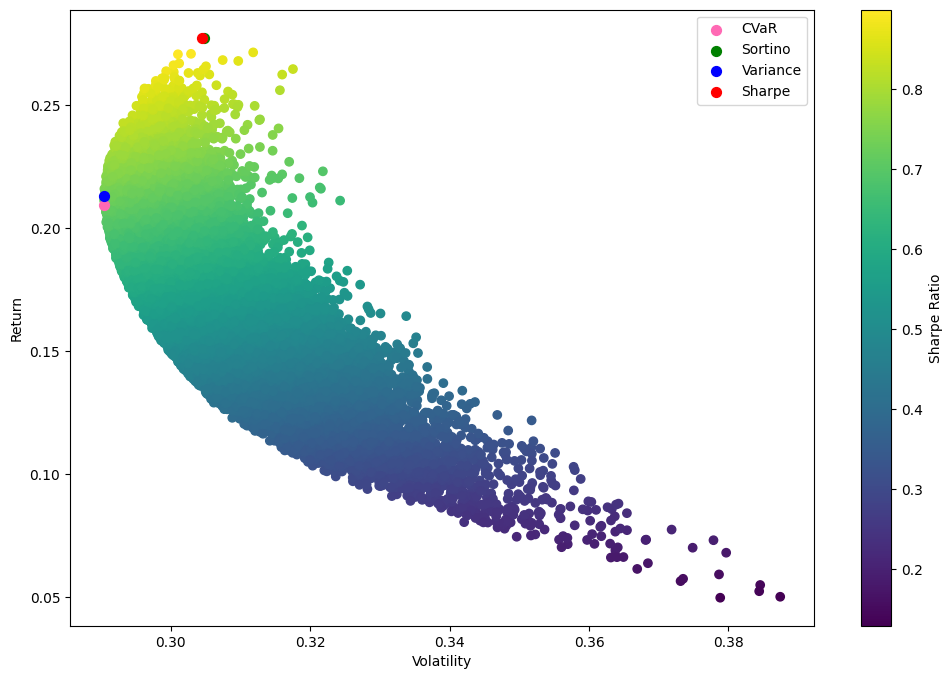





Pesos del portafolio óptimo para CVaR:


AAPL: 20.00%
MSFT: 13.11%
GOOG: 37.89%
AMZN: prácticamente 0%
META: 29.00%


Estadísticas descriptivas del portafolio óptimo para CVaR:


Retorno anualizado: 18.20
Volatilidad anualizada: 29.04
Skewness: -16.47
Kurtosis: 423.41
Max Drawdown: -37.97
Conteo de datos: 1258.00
Sharpe Ratio: 62.65
CVaR: 65.97
Ratio Sortino: 83.51
Varianza: 8.43




Pesos del portafolio óptimo para Sortino:


AAPL: 53.42%
MSFT: prácticamente 0%
GOOG: prácticamente 0%
AMZN: prácticamente 0%
META: 46.58%


Estadísticas descriptivas del portafolio óptimo para Sortino:


Retorno anualizado: 25.96
Volatilidad anualizada: 30.47
Skewness: -9.89
Kurtosis: 592.26
Max Drawdown: -29.86
Conteo de datos: 1258.00
Sharpe Ratio: 85.19
CVaR: 76.09
Ratio Sortino: 115.20
Varianza: 9.29




Pesos del portafolio óptimo para Variance:


AAPL: 21.06%
MSFT: 12.34%
GOOG: 35.93%
AMZN: prácticamente 0%
META: 30.66%


Estadísticas descriptivas del portafolio óptimo para Variance:


Retorno a

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import skew, kurtosis
from scipy.stats.mstats import gmean

# Seleccionar Criterio de Optimización
optimization_criterion = 'cvar'  # Cambia a 'sharpe', 'cvar', 'sortino' o 'variance' para optimizar esos criterios

# Elegir Acciones por agregar al Protafolio y Seleccionar periodo de muestra
symbols = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META'] #['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META']
start_date = '2018-01-01'
end_date = '2023-01-01'

data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

# Calcular los retornos
returns = data.pct_change().dropna()

# Definir la función objetivo para la optimización de la relación de Sharpe
def objective_sharpe(weights): 
    return -np.dot(weights, returns.mean()) / np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

# Definir la función objetivo para la optimización del CVaR
def objective_cvar(weights):
    portfolio_returns = np.dot(returns, weights)
    portfolio_mean = portfolio_returns.mean()
    portfolio_std = portfolio_returns.std()
    conf_level = 0.05  # Nivel de confianza para el CVaR
    cvar = portfolio_mean - portfolio_std * norm.ppf(conf_level)
    return cvar

# Definir la función objetivo para la optimización de la relación de Sortino
def objective_sortino(weights):
    portfolio_returns = np.dot(returns, weights)
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std = downside_returns.std()
    sortino_ratio = portfolio_returns.mean() / downside_std
    return -sortino_ratio  # Maximizar la relación de Sortino

# Definir la función objetivo para la minimización de la varianza
def objective_variance(weights):
    return np.dot(weights.T, np.dot(returns.cov() * 252, weights))

# Las restricciones
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Los límites para los pesos
bounds = tuple((0, 1) for x in range(len(symbols)))


# Optimización
init_guess = np.array(len(symbols) * [1. / len(symbols),])
if optimization_criterion == 'sharpe':
    opt_results = minimize(objective_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
elif optimization_criterion == 'cvar':
    opt_results = minimize(objective_cvar, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
elif optimization_criterion == 'sortino':
    opt_results = minimize(objective_sortino, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
elif optimization_criterion == 'variance':
    opt_results = minimize(objective_variance, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

# Los pesos óptimos
optimal_weights = opt_results.x


# Optimizar todos los criterios
opt_results_cvar = minimize(objective_cvar, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
opt_results_sortino = minimize(objective_sortino, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
opt_results_variance = minimize(objective_variance, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
opt_results_sharpe = minimize(objective_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

# Pesos óptimos para cada criterio
optimal_weights_cvar = opt_results_cvar.x
optimal_weights_sortino = opt_results_sortino.x
optimal_weights_variance = opt_results_variance.x
optimal_weights_sharpe = opt_results_sharpe.x

# Graficar la frontera eficiente
port_returns = []
port_volatility = []
sharpe_ratio = []
all_weights = []  # almacena los pesos de todas las carteras simuladas

num_assets = len(symbols)
num_portfolios = 50000

np.random.seed(101)

for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns_portfolio = np.dot(weights, returns.mean()) * 252
    volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sr = returns_portfolio / volatility
    sharpe_ratio.append(sr)
    port_returns.append(returns_portfolio)
    port_volatility.append(volatility)
    all_weights.append(weights)  # registra los pesos para esta cartera

plt.figure(figsize=(12, 8))
plt.scatter(port_volatility, port_returns, c=sharpe_ratio, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Calcular y graficar los retornos y la volatilidad del portafolio óptimo para cada criterio
opt_returns_cvar = np.dot(optimal_weights_cvar, returns.mean()) * 252
opt_volatility_cvar = np.sqrt(np.dot(optimal_weights_cvar.T, np.dot(returns.cov() * 252, optimal_weights_cvar)))
opt_portfolio_cvar = plt.scatter(opt_volatility_cvar, opt_returns_cvar, color='hotpink', s=50, label='CVaR')

opt_returns_sortino = np.dot(optimal_weights_sortino, returns.mean()) * 252
opt_volatility_sortino = np.sqrt(np.dot(optimal_weights_sortino.T, np.dot(returns.cov() * 252, optimal_weights_sortino)))
opt_portfolio_sortino = plt.scatter(opt_volatility_sortino, opt_returns_sortino, color='g', s=50, label='Sortino')

opt_returns_variance = np.dot(optimal_weights_variance, returns.mean()) * 252
opt_volatility_variance = np.sqrt(np.dot(optimal_weights_variance.T, np.dot(returns.cov() * 252, optimal_weights_variance)))
opt_portfolio_variance = plt.scatter(opt_volatility_variance, opt_returns_variance, color='b', s=50, label='Variance')

opt_returns_sharpe = np.dot(optimal_weights_sharpe, returns.mean()) * 252
opt_volatility_sharpe = np.sqrt(np.dot(optimal_weights_sharpe.T, np.dot(returns.cov() * 252, optimal_weights_sharpe)))
opt_portfolio_sharpe = plt.scatter(opt_volatility_sharpe, opt_returns_sharpe, color='r', s=50, label='Sharpe')

plt.legend(loc='upper right')

plt.show()


# Función para calcular el drawdown máximo
def max_drawdown(return_series):
    comp_ret = (1 + return_series).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak) - 1
    return dd.min()

# Función para calcular estadísticas descriptivas más detalladas
def detailed_portfolio_statistics(weights):
    portfolio_returns = returns.dot(weights)
    
    # Estadísticas descriptivas generales
    mean_return_annualized = gmean(portfolio_returns + 1)**252 - 1
    std_dev_annualized = portfolio_returns.std() * np.sqrt(252)
    skewness = skew(portfolio_returns)
    kurt = kurtosis(portfolio_returns)
    max_dd = max_drawdown(portfolio_returns)
    count = len(portfolio_returns)
    
    # Métricas de optimización
    risk_free_rate = 0.00
    sharpe_ratio = (mean_return_annualized - risk_free_rate) / std_dev_annualized
    conf_level = 0.05
    cvar = mean_return_annualized - std_dev_annualized * norm.ppf(conf_level)
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std_dev = downside_returns.std() * np.sqrt(252)
    sortino_ratio = mean_return_annualized / downside_std_dev
    variance = std_dev_annualized ** 2 
    
    return mean_return_annualized, std_dev_annualized, skewness, kurt, max_dd, count, sharpe_ratio, cvar, sortino_ratio, variance

# Calcular estadísticas para cada portafolio
statistics_cvar = detailed_portfolio_statistics(optimal_weights_cvar)
statistics_sortino = detailed_portfolio_statistics(optimal_weights_sortino)
statistics_variance = detailed_portfolio_statistics(optimal_weights_variance)
statistics_sharpe = detailed_portfolio_statistics(optimal_weights_sharpe)

# Nombres de las estadísticas
statistics_names = ['Retorno anualizado', 'Volatilidad anualizada', 'Skewness', 'Kurtosis', 'Max Drawdown', 'Conteo de datos', 'Sharpe Ratio', 'CVaR', 'Ratio Sortino', 'Varianza']

# Diccionario que asocia los nombres de los métodos de optimización con los pesos óptimos y las estadísticas
portfolio_data = {
    'CVaR': {
        'weights': optimal_weights_cvar,
        'statistics': detailed_portfolio_statistics(optimal_weights_cvar)
    },
    'Sortino': {
        'weights': optimal_weights_sortino,
        'statistics': detailed_portfolio_statistics(optimal_weights_sortino)
    },
    'Variance': {
        'weights': optimal_weights_variance,
        'statistics': detailed_portfolio_statistics(optimal_weights_variance)
    },
    'Sharpe': {
        'weights': optimal_weights_sharpe,
        'statistics': detailed_portfolio_statistics(optimal_weights_sharpe)
    },
}

# Imprimir los pesos y las estadísticas para cada método de optimización
for method, data in portfolio_data.items():
    print("\n")
    print("========================================================================================================")
    print("\n")
    print(f"Pesos del portafolio óptimo para {method}:")
    print("\n")
    for symbol, weight in zip(symbols, data['weights']):
        if weight < 1e-4:  # considera cualquier peso menor que 0.01% como cero
            print(f"{symbol}: prácticamente 0%")
        else:
            print(f"{symbol}: {weight*100:.2f}%")

    print("\n")
    print(f"Estadísticas descriptivas del portafolio óptimo para {method}:")
    print("\n")
    for name, stat in zip(statistics_names, data['statistics']):
        print(f"{name}: {stat*100 if name != 'Conteo de datos' else stat:.2f}")

print("\n")
print("========================================================================================================")


In [2]:
import sys

# Guarda la salida estándar original
original_stdout = sys.stdout 

# Abre un archivo para escribir la salida
with open('output.txt', 'w') as f:
    sys.stdout = f  # Cambia la salida estándar al archivo que acabamos de abrir

    # Aquí va tu código
    print("Aquí va tu código")

# Restaura la salida estándar original
sys.stdout = original_stdout